Purpose: To re-make confusion matrices for the models run at the end of June-beginning of July. Initially, the confusion matrices were plotted over the ROC curves, which is incorrect and, well, confusing.<br>
Author: Anna Pardo<br>
Date initiated: July 5, 2023

In [1]:
# import modules
import numpy as np
import pandas as pd
import random
import json
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler

In [14]:
# function for plotting confusion matrix
def plot_confusion_matrix(cm,filename,classes=[0,1],normalize=False,cmap=plt.cm.Blues):
    """
    Args:
        cm = confusion matrix
        classes = a list of the classes, default [0,1]
        normalize = Boolean variable stating whether to normalize, default False
        cmap = colormap to use, default Blues
        filename = filename with directory path, no extension
    """
    title = 'Confusion matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized ' + title

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename+".png",bbox_inches="tight")
    plt.savefig(filename+".pdf",bbox_inches="tight")

In [3]:
# load one of the hyperparameter JSON files and look at it
fhyp = json.load(open("../../data/rf_outputs/hyperparameters/FloodingTest_Up_Hyperparameters.json"))
fhyp

{'bootstrap': False,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 80,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 800,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

In [4]:
# try regenerating the model
rfclf_tuned = RandomForestClassifier(n_estimators=fhyp["n_estimators"],
                                    min_samples_split=fhyp["min_samples_split"],
                                    min_samples_leaf=fhyp["min_samples_leaf"],
                                    max_features=fhyp["max_features"],
                                    max_depth=fhyp["max_depth"],
                                    bootstrap=fhyp["bootstrap"])

In [5]:
# load TPM data
def load_clean_data(path_to_tpm,single_stress="none"):
    """
    Args:
        path_to_tpm = full path to file containing raw TPM, columns for Sample, BioProject, & Treatment
        single_stress = a single stressor to which the data must be subsetted, or "none" (default)
    """
    # load the TPM data
    raw_tpm = pd.read_csv(path_to_tpm,sep="\t",header="infer")
    # if there is a single stress to subset to, subset to that stress
    if single_stress != "none":
        if single_stress == "Drought":
            raw_tpm = raw_tpm[raw_tpm["Treatment"].isin(["Drought","DroughtRepeat","Control"])]
        else:
            raw_tpm = raw_tpm[raw_tpm["Treatment"].isin([single_stress,"Control"])]
        # remove BioProjects that only have control samples left
        testdf = raw_tpm[["Sample","BioProject","Treatment"]]
        for b in testdf["BioProject"].unique():
            df = testdf[testdf["BioProject"]==b]
            if len(df["Treatment"].unique())==1:
                testdf = testdf[testdf["BioProject"]!=b]
        raw_tpm = raw_tpm.merge(testdf)
    # labeling: set Control to 0 and any stress to 1
    proxy = []
    for i in range(len(raw_tpm.index)):
        if raw_tpm.iloc[i,raw_tpm.columns.get_loc("Treatment")] == "Control":
            proxy.append(0)
        else:
            proxy.append(1)
    raw_tpm["Label"] = proxy
    # return the dataframe
    return raw_tpm

In [6]:
tpm = load_clean_data("../../data/rawtpm_bptreat_noPEG.tsv")

In [7]:
tpm.head()

,Sample,BioProject,Treatment,Zm00001eb000010,Zm00001eb000020,Zm00001eb000050,Zm00001eb000060,Zm00001eb000070,Zm00001eb000080,Zm00001eb000100,...,Zm00001eb442820,Zm00001eb442840,Zm00001eb442850,Zm00001eb442870,Zm00001eb442890,Zm00001eb442910,Zm00001eb442960,Zm00001eb442980,Zm00001eb443030,Label
0,SRR11933261,PRJNA637522,Drought,12.553818,2.321077,0.042520,12.932676,5.253755,11.105837,0.409268,...,0.000000,0.0,0.0,0.0,0.309501,0.0,0.000000,0.0,0.000000,1
1,SRR11933272,PRJNA637522,Drought,16.255838,3.110372,0.405226,7.214039,1.902461,2.346186,0.170305,...,0.127878,0.0,0.0,0.0,6.703281,0.0,0.000000,0.0,0.000000,1
2,SRR11933250,PRJNA637522,Drought,9.028815,2.984479,0.000000,3.092442,2.586555,16.186141,0.000000,...,0.000000,0.0,0.0,0.0,0.417565,0.0,0.254123,0.0,1.213349,1
3,SRR11933029,PRJNA637522,Control,8.201340,2.385748,0.000000,1.726808,1.926412,19.600487,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,1.370075,0
4,SRR11933040,PRJNA637522,Drought,10.371251,2.799099,0.000000,1.280629,3.771234,19.717683,0.143764,...,0.012158,0.0,0.0,0.0,9.625225,0.0,0.000000,0.0,2.352959,1


In [8]:
def variance_threshold_selector(data):
    selector = VarianceThreshold()
    selector.fit(data)
    return data[data.columns[selector.get_support(indices=True)]]

def check_if_balanced(labeled_tpm):
    """
    Args:
        labeled_tpm = raw TPM with columns for Sample, BioProject, Label, Treatment
    """
    if labeled_tpm["Label"].value_counts()[0] == labeled_tpm["Label"].value_counts()[1]:
        return True
    else:
        return False

def downsample(dataframe):
    """
    Args:
        dataframe = a log TPM dataframe with a Label column and Sample set as the index
    """
    # generate a variable of value counts
    vc = dataframe["Label"].value_counts()

    # subset data to only samples labeled 1
    ones_only = dataframe[dataframe["Label"]==1]

    # downsample from the subsetted dataframe
    ds = ones_only.sample(n=vc[1],random_state=42)

    # subset original data to control samples
    zeroes = dataframe[dataframe["Label"]==0]

    # concatenate controls and downsampled stress samples
    downsampled = pd.concat([ds,zeroes])
    # return dataframe
    return downsampled

In [9]:
def pre_split_transform(raw_tpm,balanced,downsample=False):
    """
    Args:
        raw_tpm = dataframe containing raw TPM values, columns for Sample, BioProject, Treatment, Label
        balanced = Boolean variable, True or False (result of check_if_balanced())
        downsample = Boolean variable, True or False, default False (set manually outside function)
    """
    # if data have treatment column, drop it
    #if "Treatment" in raw_tpm.columns:
    #    raw_tpm = raw_tpm.drop("Treatment",axis=1)
    # temporarily, set index to Sample and drop BioProject, Label, & Treatment columns
    blt = raw_tpm[["Sample","BioProject","Treatment","Label"]]
    tpmi = raw_tpm.set_index("Sample").drop(["BioProject","Treatment","Label"],axis=1)
    # remove zero-variance genes
    vttpm = variance_threshold_selector(tpmi)
    # log-transform TPM
    vttpm_log = vttpm.apply(lambda x: np.log2(x+1))
    # downsample data if needed
    if balanced==True:
        if downsample==True:
            # add back labels
            vttpm_log = blt[["Sample","Label"]].merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
            # set Sample as index
            vttpm_log = vttpm_log.set_index("Sample")
            # downsample the data
            vttpm_log = downsample(vttpm_log)
    # add treatment, labels, and BioProject back in, set Sample as the index again
    labeled = blt.merge(vttpm_log.reset_index().rename(columns={"index":"Sample"}))
    labeled.set_index("Sample",inplace=True)
    # drop rows containing NaN values
    labeled = labeled.dropna(axis=0)
    # return dataframe
    return labeled

In [10]:
def split_prep_stressor(stressor,dataframe,balance="Up"):
    """
    Args:
        stressor = stressor to hold out for testing (all BioProjects)
        dataframe = log TPM dataframe with Sample, Label, BioProject, Treatment columns (or Sample as index)
        balance = str: "none","up" (downsampling will be done before splitting, outside of this function)
    """
    # in case Sample isn't already a column, reset the index and rename the column to Sample
    if "Sample" not in dataframe.columns:
        dataframe = dataframe.reset_index().rename(columns={"index":"Sample"})
    # generate list of unique BioProjects containing the test stressor
    sbp = dataframe[dataframe["Treatment"]==stressor]["BioProject"].unique()
    # split test from train data
    test = dataframe[dataframe["BioProject"].isin(sbp)]
    test = test[test["Treatment"].isin([stressor,"Control"])]
    # pull out training data
    train = dataframe[~dataframe["Sample"].isin(test["Sample"])]
    # for both sets, make Sample the index again
    test = test.set_index("Sample")
    train = train.set_index("Sample")
    # drop BioProject and Treatment columns from both sets
    test = test.drop(["BioProject","Treatment"],axis=1)
    train = train.drop(["BioProject","Treatment"],axis=1)
    # generate X_train, X_test, y_train, and y_test
    ## where X = gene expression values and y = class labels
    train_X = train.drop("Label",axis=1)
    y_train = train["Label"]
    test_X = test.drop("Label",axis=1)
    y_test = test["Label"]
    # if upsampling: do the upsampling using SMOTE
    if balance=="up":
        sm = SMOTE(random_state=42)
        train_X, y_train = sm.fit_resample(train_X,y_train)
    # for X_train and X_test: scale data to a z-score
    scalar = StandardScaler()
    X_train = scalar.fit_transform(train_X)
    X_test = scalar.fit_transform(test_X)
    # return training and test data
    return X_train, y_train, X_test, y_test

In [11]:
# define a function to regenerate the confusion matrix for a given stressor
def cm_stressor(stressor,tpmdf):
    # load hyperparameters for this stressor
    hyp = json.load(open("../../data/rf_outputs/hyperparameters/"+stressor+"Test_Up_Hyperparameters.json"))
    
    # set sampling and balance variables
    bal = check_if_balanced(tpmdf)
    ds = False
    us = "Up"
    
    # log transform data
    logtpm = pre_split_transform(tpmdf,bal,ds)
    
    # split data into train & test sets
    X_train, y_train, X_test, y_test = split_prep_stressor(stressor,logtpm,us)
    
    # regenerate the random forest model
    rfclf_tuned = RandomForestClassifier(n_estimators=hyp["n_estimators"],
                                        min_samples_split=hyp["min_samples_split"],
                                        min_samples_leaf=hyp["min_samples_leaf"],
                                        max_features=hyp["max_features"],
                                        max_depth=hyp["max_depth"],
                                        bootstrap=hyp["bootstrap"])
    
    # fit model on training data
    rfclf_tuned.fit(X_train,y_train)
    
    # make predictions on test set
    y_pred = rfclf_tuned.predict(X_test)
    
    # generate output filename
    f = "../../figures/rf_results/new_confusion_matrices/"+stressor+"Test_Up_ConfusionMatrix"
    
    # make confusion matrix
    cm = confusion_matrix(y_test,y_pred)
    # plot confusion matrix
    plot_confusion_matrix(cm,f)

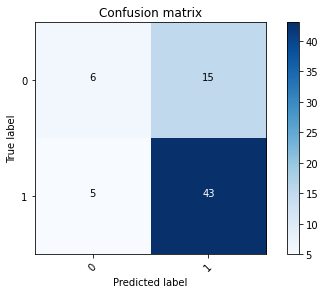

In [15]:
# run for flooding
cm_stressor("Flooding",tpm)

This is actually invalid. Even though I am running the model with the same hyperparameters, I'm basically running technical reps because it's generating new results each time. Thus the original confusion matrices are not recoverable.